# Apply AI Superresolution to video - Train ESPCN from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction



## Share results
- put out an example on youtube to allow comparison



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train espcn with hres perception loss multifuz.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [15]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [16]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(self.kernel_size)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [18]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


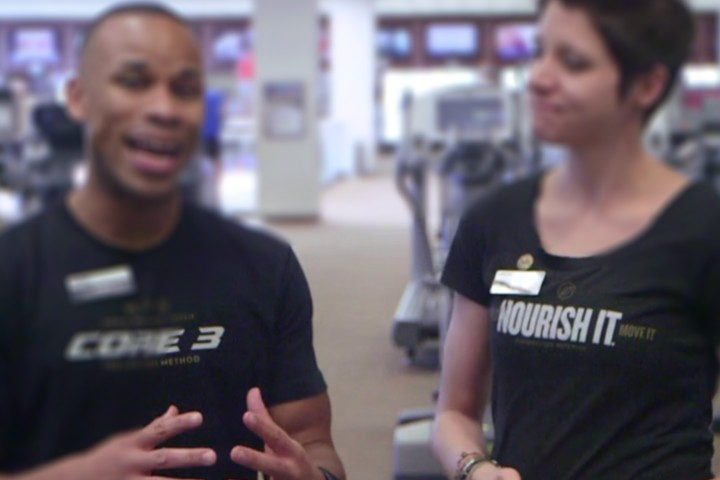

In [19]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [20]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [21]:
#settings
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 32 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(1,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [22]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [23]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [24]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [25]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([32, 1, 480, 720])


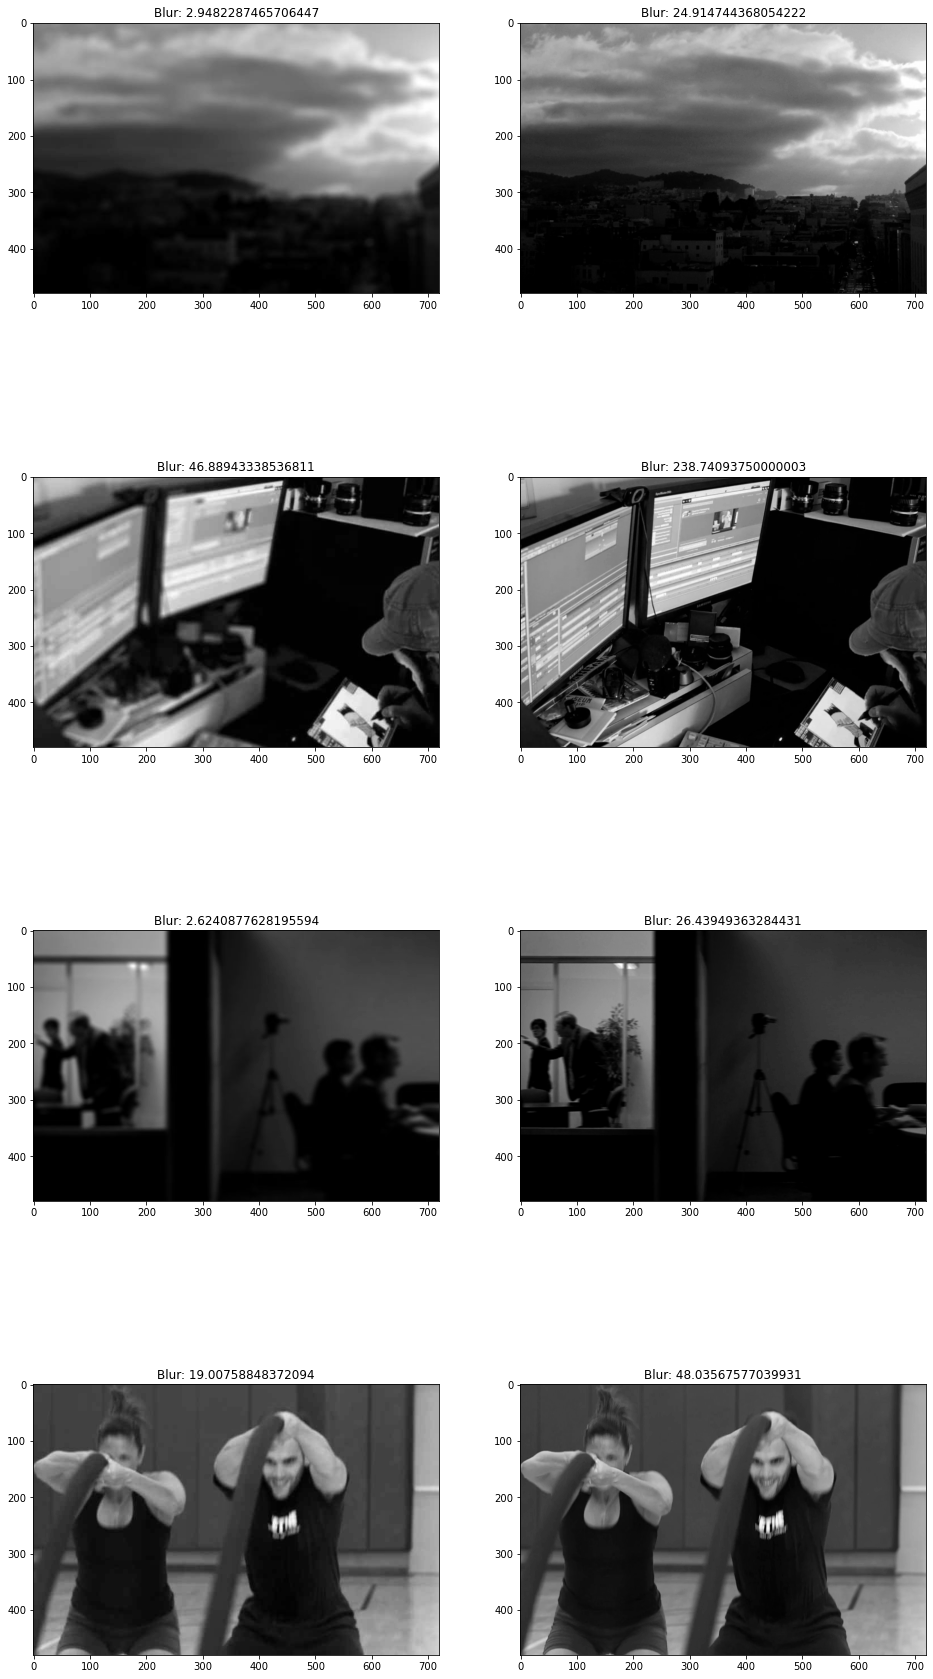

In [26]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class VDSRNet(nn.Module):
    def __init__(self):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    


# ESPCN

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class ESPCNNet(nn.Module):
    def __init__(self, upscale_factor):
        super(ESPCNNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        #x = F.tanh(self.conv1(x))
        #x = F.tanh(self.conv2(x))
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = F.sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x
    
# Make it use a residual approach -Add the network to bicubic interpolation at end resolution - just like VDSR

# Build the model

In [28]:
#model = VDSRNet()
model = ESPCNNet(upscale_factor=1)
model.cuda()


ESPCNNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=1)
  (relu): ReLU(inplace=True)
)

In [ ]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



In [31]:
from torchsummary import summary
summary(model, (1, 480, 720));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 480, 720]        1,664
├─ReLU: 1-2                              [-1, 64, 480, 720]        --
├─Conv2d: 1-3                            [-1, 32, 480, 720]        18,464
├─ReLU: 1-4                              [-1, 32, 480, 720]        --
├─Conv2d: 1-5                            [-1, 1, 480, 720]         289
├─PixelShuffle: 1-6                      [-1, 1, 480, 720]         --
Total params: 20,417
Trainable params: 20,417
Non-trainable params: 0
Total mult-adds (G): 7.02
Input size (MB): 1.32
Forward/backward pass size (MB): 255.76
Params size (MB): 0.08
Estimated Total Size (MB): 257.16


In [32]:
criterion2 = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [43]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        
        # approach to split image into blocks since loss works on 256x256 images
        for i in [0, 224]:
            for j in [0, 232, 464 ]:
                x_crop = x[:,:,i:i+255, j:j+255]
                y_crop = y[:,:,i:i+255, j:j+255]
                totloss.add_(torch.mean(loss_fn.forward(loss_scaler(x_crop),loss_scaler(y_crop)))/6)
        
        #print("before:",totloss)
        
        #also use mse loss
        #totloss.add_(torch.mean(loss_fn_2.forward(x,y)))
        
        #print("after:",totloss)
        #do we need to work in color?
        
        return totloss

In [44]:
list(range(0,1280-256,256-int((256*6-1280)/5)))

[0, 205, 410, 615, 820]

In [45]:
list(range(0,720-256,256-int((256*3-720)/2)))

[0, 232]

In [46]:
criterion = P_Loss()

#criterion.cuda()

In [33]:
init_lr = .01
lr_step = 2
gradient_clip = 0.4
epochs = 12

In [34]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [35]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [36]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [37]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "ESPCN1_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [38]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [47]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            #loss = criterion(output, target) + criterion2(output, target)/5000.0
            loss = criterion2(output, target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [48]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Start Time: 2020-09-29 16:49:38.854983
Epoch = 1, lr = 0.01
===> Time: 2020-09-29 16:50:30.284967 Epoch[1](10/199): LR: 0.01 : Loss: 33301.9570312500
===> Time: 2020-09-29 16:51:21.747360 Epoch[1](20/199): LR: 0.01 : Loss: 34811.3750000000
===> Time: 2020-09-29 16:52:12.816085 Epoch[1](30/199): LR: 0.01 : Loss: 20870.5917968750
===> Time: 2020-09-29 16:53:03.068935 Epoch[1](40/199): LR: 0.01 : Loss: 6112.0864257812
===> Time: 2020-09-29 16:53:53.685820 Epoch[1](50/199): LR: 0.01 : Loss: 3973.1501464844
===> Time: 2020-09-29 16:54:44.113561 Epoch[1](60/199): LR: 0.01 : Loss: 4061.5339355469
===> Time: 2020-09-29 16:55:33.371316 Epoch[1](70/199): LR: 0.01 : Loss: 4789.2924804688
===> Time: 2020-09-29 16:56:23.321843 Epoch[1](80/199): LR: 0.01 : Loss: 3667.6286621094
===> Time: 2020-09-29 16:57:13.783211 Epoch[1](90/199): LR: 0.01 : Loss: 2844.7436523438
===> Time: 2020-09-29 16:58:03.269016 Epoch[1](100/199): LR: 0.01 : Loss: 2831.7626953125
===> Time: 2020-09-29 16:58:51.423180 Epoch[1]

===> Time: 2020-09-29 17:54:04.084324 Epoch[5](20/199): LR: 0.001 : Loss: 1956.0328369141
===> Time: 2020-09-29 17:54:51.850163 Epoch[5](30/199): LR: 0.001 : Loss: 2261.8518066406
===> Time: 2020-09-29 17:55:38.149167 Epoch[5](40/199): LR: 0.001 : Loss: 1983.6767578125
===> Time: 2020-09-29 17:56:24.949557 Epoch[5](50/199): LR: 0.001 : Loss: 2250.8981933594
===> Time: 2020-09-29 17:57:11.797467 Epoch[5](60/199): LR: 0.001 : Loss: 2280.9316406250
===> Time: 2020-09-29 17:57:59.070852 Epoch[5](70/199): LR: 0.001 : Loss: 2366.2009277344
===> Time: 2020-09-29 17:58:45.740265 Epoch[5](80/199): LR: 0.001 : Loss: 2053.3095703125
===> Time: 2020-09-29 17:59:32.787316 Epoch[5](90/199): LR: 0.001 : Loss: 1957.0579833984
===> Time: 2020-09-29 18:00:20.211426 Epoch[5](100/199): LR: 0.001 : Loss: 2393.0356445312
===> Time: 2020-09-29 18:01:07.379034 Epoch[5](110/199): LR: 0.001 : Loss: 2458.0065917969
===> Time: 2020-09-29 18:01:53.407839 Epoch[5](120/199): LR: 0.001 : Loss: 1772.5015869141
===> Ti

===> Time: 2020-09-29 18:56:45.414032 Epoch[9](30/199): LR: 0.00010000000000000002 : Loss: 1819.4934082031
===> Time: 2020-09-29 18:57:31.893488 Epoch[9](40/199): LR: 0.00010000000000000002 : Loss: 1841.7791748047
===> Time: 2020-09-29 18:58:18.477726 Epoch[9](50/199): LR: 0.00010000000000000002 : Loss: 2103.9697265625
===> Time: 2020-09-29 18:59:05.024263 Epoch[9](60/199): LR: 0.00010000000000000002 : Loss: 1875.0555419922
===> Time: 2020-09-29 18:59:52.121890 Epoch[9](70/199): LR: 0.00010000000000000002 : Loss: 1888.5734863281
===> Time: 2020-09-29 19:00:39.354979 Epoch[9](80/199): LR: 0.00010000000000000002 : Loss: 2563.0144042969
===> Time: 2020-09-29 19:01:28.463518 Epoch[9](90/199): LR: 0.00010000000000000002 : Loss: 1985.0367431641
===> Time: 2020-09-29 19:02:16.005230 Epoch[9](100/199): LR: 0.00010000000000000002 : Loss: 1949.7756347656
===> Time: 2020-09-29 19:03:04.565882 Epoch[9](110/199): LR: 0.00010000000000000002 : Loss: 1616.4199218750
===> Time: 2020-09-29 19:03:51.8546

===> Time: 2020-09-29 19:55:08.187101 Epoch[12](180/199): LR: 3.16227766016838e-05 : Loss: 2053.0070800781
===> Time: 2020-09-29 19:55:54.927954 Epoch[12](190/199): LR: 3.16227766016838e-05 : Loss: 2592.3544921875
Epoch Loss: tensor(2004.4973, device='cuda:0')
Checkpoint saved to checkpoint/ESPCN1_epoch_12.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [49]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [50]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [51]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [52]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [53]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [54]:
def display_PSNR(im_gt, im_b, im_in, model, display=True):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(141)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(142)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(143)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(144)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [55]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/ESPCN1_epoch_12.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

In [56]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(2,2))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for Model is 15.356507324898754dB
PSNR improvement is -5.468141635143009dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 188.56071816547774
Sharpness Measurement Model: 345.28010435565375


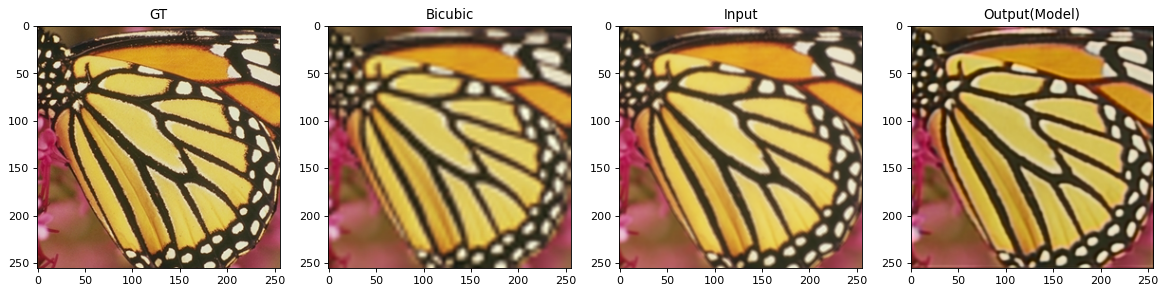

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F9D66306970>,
 20.824648960041763,
 15.356507324898754)

In [57]:
display_PSNR(im_gt, im_b, im_b2, model)


In [ ]:
im_gt.size

In [58]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 20.90886905719583dB
psnr for Model is 19.95316673588504dB
PSNR improvement is -0.9557023213107882dB
Sharpness Measurement GroundTruth: 5109.0955266965975
Sharpness Measurement Bicubic: 15.83579055305556
Sharpness Measurement Input: 21.051232107708337
Sharpness Measurement Model: 25.728008609375


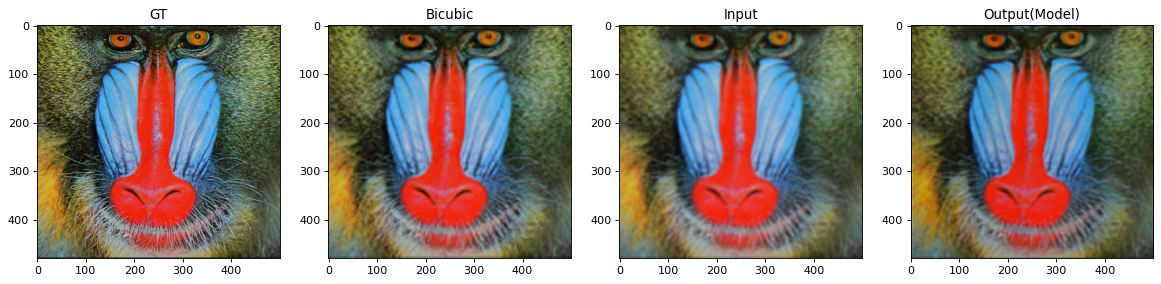

psnr for bicubic is 24.308655657370245dB
psnr for Model is 22.940608970158223dB
PSNR improvement is -1.368046687212022dB
Sharpness Measurement GroundTruth: 1139.0247193743783
Sharpness Measurement Bicubic: 22.619108417905434
Sharpness Measurement Input: 17.99254485000458
Sharpness Measurement Model: 19.037523961753305


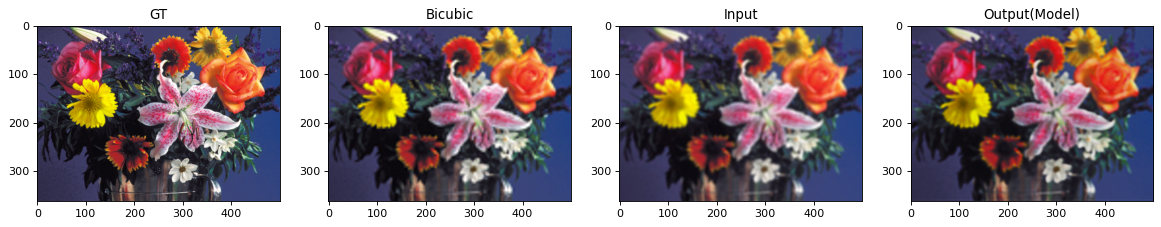

psnr for bicubic is 28.58001966637357dB
psnr for Model is 24.226360918468416dB
PSNR improvement is -4.353658747905154dB
Sharpness Measurement GroundTruth: 497.13785915203334
Sharpness Measurement Bicubic: 11.100006092106923
Sharpness Measurement Input: 9.885738230179413
Sharpness Measurement Model: 30.68662762682652


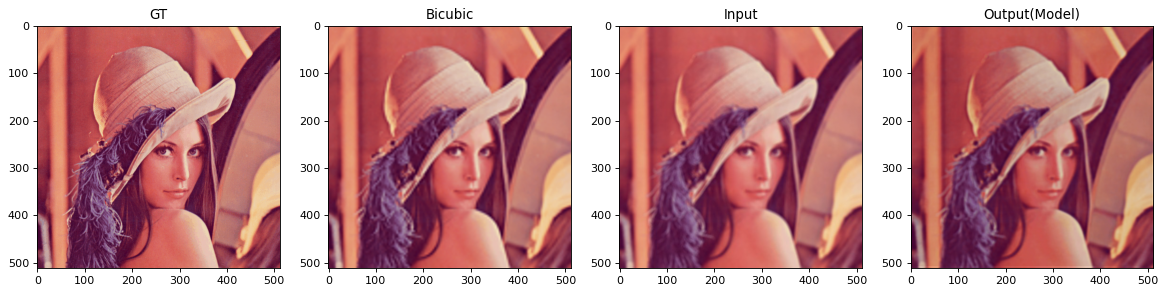

psnr for bicubic is 20.388685221991302dB
psnr for Model is 19.020556224784876dB
PSNR improvement is -1.3681289972064263dB
Sharpness Measurement GroundTruth: 3181.438977407284
Sharpness Measurement Bicubic: 37.289469999876545
Sharpness Measurement Input: 31.34700973777778
Sharpness Measurement Model: 76.39441706222222


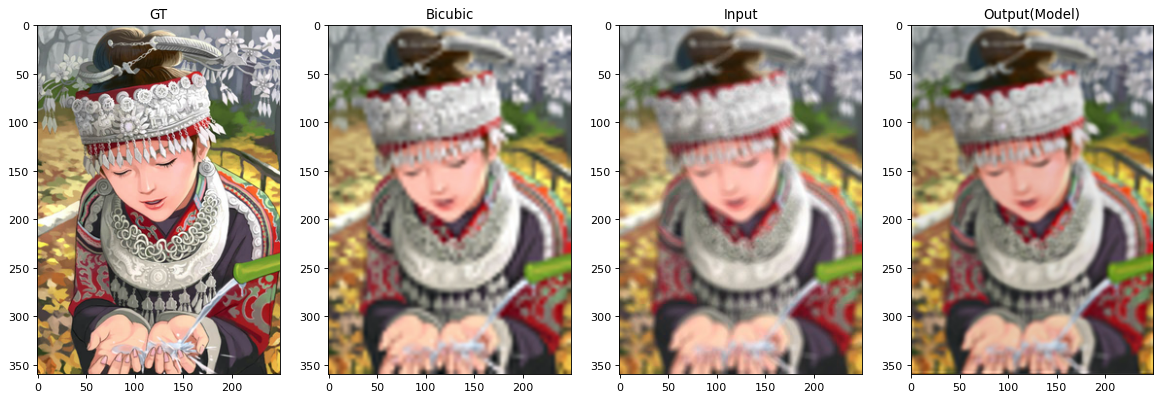

psnr for bicubic is 30.347062508210048dB
psnr for Model is 26.76190982539264dB
PSNR improvement is -3.5851526828174087dB
Sharpness Measurement GroundTruth: 595.7572052363794
Sharpness Measurement Bicubic: 5.924464354118902
Sharpness Measurement Input: 6.287333070855138
Sharpness Measurement Model: 30.999006963206476


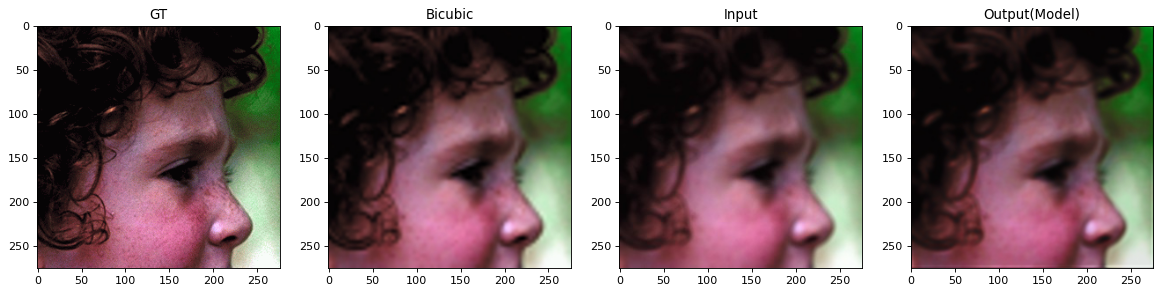

psnr for bicubic is 23.055781743818507dB
psnr for Model is 21.573152230256348dB
PSNR improvement is -1.4826295135621592dB
Sharpness Measurement GroundTruth: 2376.0941899851314
Sharpness Measurement Bicubic: 19.785036861649132
Sharpness Measurement Input: 16.345737375420867
Sharpness Measurement Model: 31.90872353244049


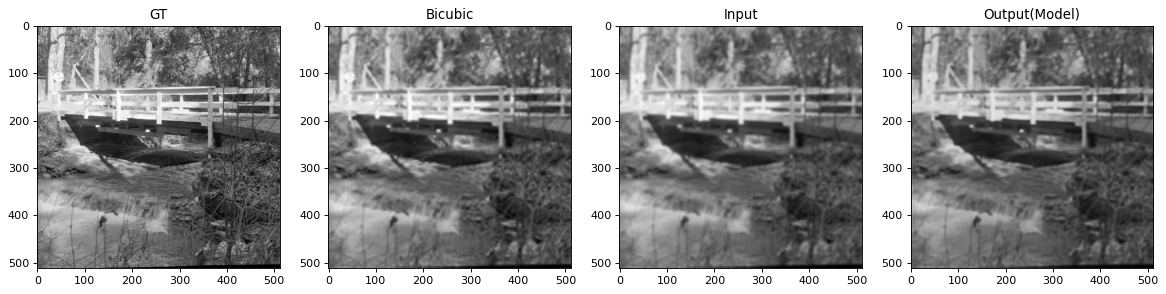

psnr for bicubic is 22.969555994679638dB
psnr for Model is 20.544091695738818dB
PSNR improvement is -2.4254642989408204dB
Sharpness Measurement GroundTruth: 938.4126397093572
Sharpness Measurement Bicubic: 44.872761652286144
Sharpness Measurement Input: 27.378348943398468
Sharpness Measurement Model: 80.83743872633683


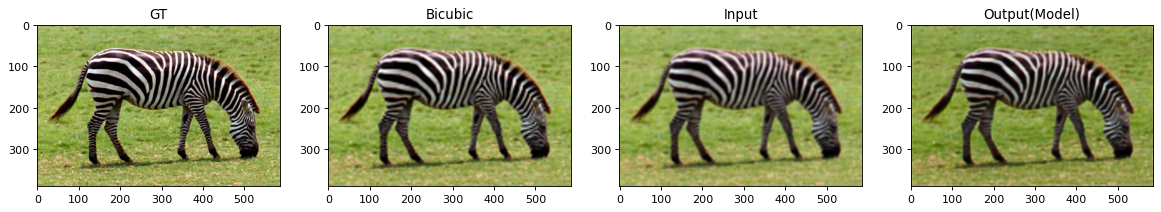

psnr for bicubic is 20.706514438784392dB
psnr for Model is 18.701359842666086dB
PSNR improvement is -2.005154596118306dB
Sharpness Measurement GroundTruth: 1927.3090995493055
Sharpness Measurement Bicubic: 39.040601296742174
Sharpness Measurement Input: 28.53499432851253
Sharpness Measurement Model: 61.20918058935116


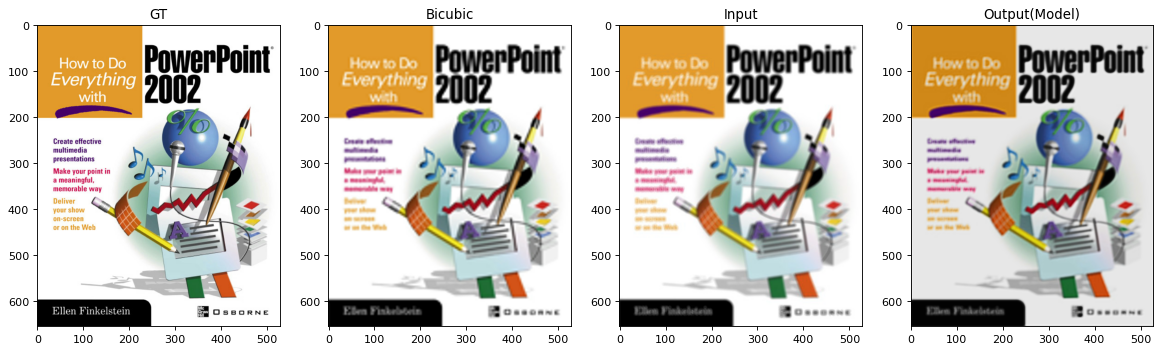

psnr for bicubic is 25.99703094531924dB
psnr for Model is 22.831617027008036dB
PSNR improvement is -3.1654139183112022dB
Sharpness Measurement GroundTruth: 739.6683709929154
Sharpness Measurement Bicubic: 15.413530136928086
Sharpness Measurement Input: 12.86552357116581
Sharpness Measurement Model: 54.0803443092118


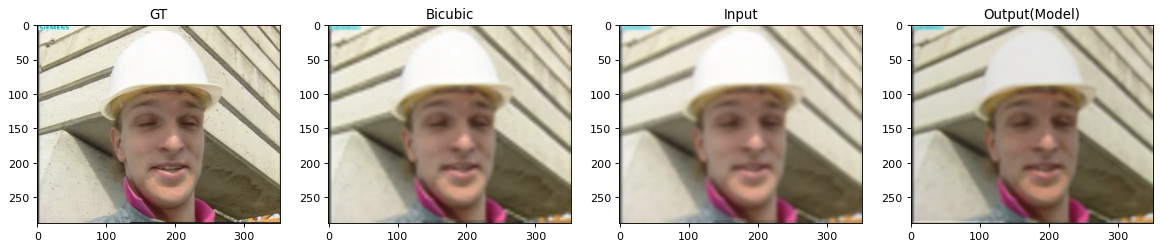

psnr for bicubic is 26.225282739431904dB
psnr for Model is 24.23512143623013dB
PSNR improvement is -1.9901613032017735dB
Sharpness Measurement GroundTruth: 625.6135935834542
Sharpness Measurement Bicubic: 21.235857645612366
Sharpness Measurement Input: 15.449333168404543
Sharpness Measurement Model: 25.038103303949658


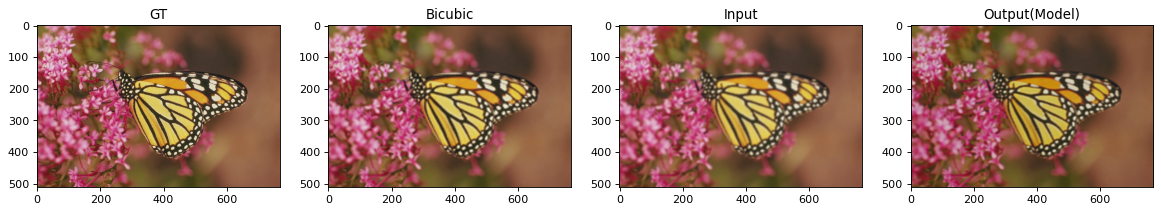

psnr for bicubic is 27.87546946255926dB
psnr for Model is 24.16467088448414dB
PSNR improvement is -3.7107985780751207dB
Sharpness Measurement GroundTruth: 785.671896489439
Sharpness Measurement Bicubic: 10.848251492236159
Sharpness Measurement Input: 10.850798537474475
Sharpness Measurement Model: 36.09206543856999


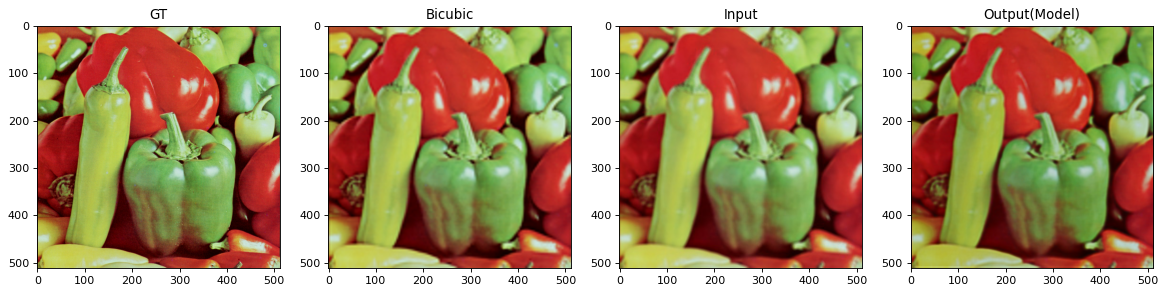

psnr for bicubic is 23.983173916209335dB
psnr for Model is 21.614510126460015dB
PSNR improvement is -2.36866378974932dB
Sharpness Measurement GroundTruth: 1044.1713580036271
Sharpness Measurement Bicubic: 11.743170487662988
Sharpness Measurement Input: 11.847468523769498
Sharpness Measurement Model: 56.86596701863031


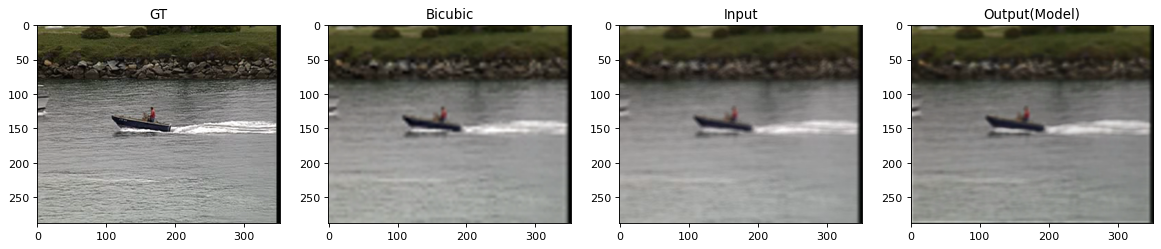

psnr for bicubic is 24.410421920003333dB
psnr for Model is 22.577569048255985dB
PSNR improvement is -1.832852871747349dB
Sharpness Measurement GroundTruth: 1773.856239214525
Sharpness Measurement Bicubic: 18.433340376010165
Sharpness Measurement Input: 14.513362199286348
Sharpness Measurement Model: 27.826136772389873


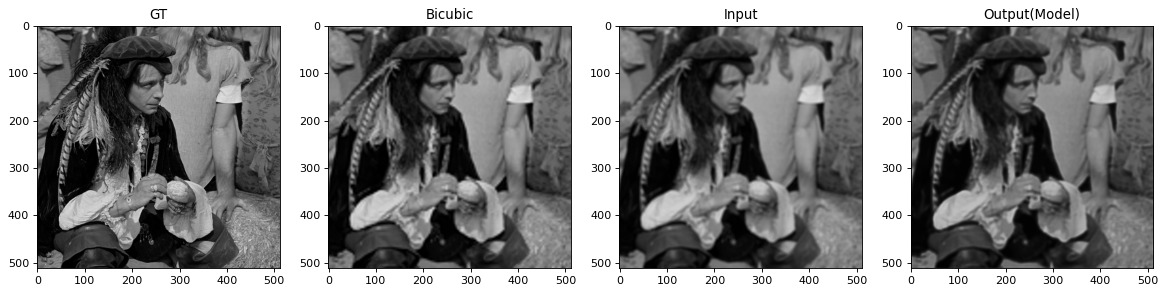

psnr for bicubic is 23.79600530162264dB
psnr for Model is 22.03707488974601dB
PSNR improvement is -1.75893041187663dB
Sharpness Measurement GroundTruth: 1943.9403096163192
Sharpness Measurement Bicubic: 13.533079124837908
Sharpness Measurement Input: 13.649269657370485
Sharpness Measurement Model: 15.646601926957374


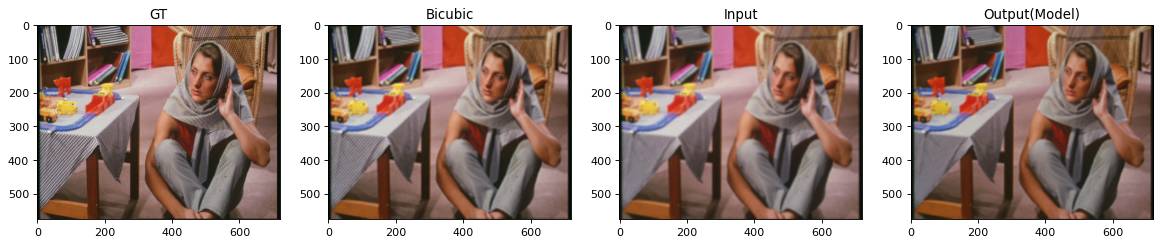

Bicubic average PSNR = 24.539466326683517
Model average PSNR = 22.227269275395344


In [76]:
test_results("/media/SSD/superres/video_data/test_data/Set14", 4, display = True)

# convert sample videos

In [79]:
folder = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/"

In [60]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn1-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|▏         | 13/900 [00:00<00:06, 129.23it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuzmuffins30secespcn1-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:09<00:00, 92.69it/s] 


True

In [61]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn1-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  5%|▌         | 47/900 [00:00<00:01, 469.16it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuzmuffins30secespcn1-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:02<00:00, 330.15it/s]


True

In [62]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn1-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 10/900 [00:00<00:08, 99.54it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuzmuffins30secespcn1-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:12<00:00, 74.39it/s]


True

In [63]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secespcn1-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 5/900 [00:00<00:18, 48.16it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuzmuffins30secespcn1-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [00:20<00:00, 44.19it/s]


True

In [64]:
dualfile= folder + "muffins30secespcn1-30dual.mp4"

In [65]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [66]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [67]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8hespcn1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuzsuper8hespcn1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


  0%|          | 0/7195 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 7195/7195 [01:15<00:00, 94.74it/s] 


True

In [68]:

dualfile= folder + "super8espcn1dual.mp4"

In [69]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [82]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel2.mp4"
outfile = folder + "super8espcn1.mp4"
outfile = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/super8hespcn1.mp4"
dualfile= folder + "super8espcn1-tolast-dual.mp4"

In [83]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [72]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longespcn1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuzsuper8longespcn1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


  0%|          | 0/121409 [00:00<?, ?it/s]/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 121409/121409 [17:43<00:00, 114.18it/s]


True

In [73]:
dualfile= folder + "super8longespcn1dual.mp4"

In [74]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}